Questo prende la lista di velocità di tutti i veicoli di un video e ci fa un grafico delle emissioni, per diversi modelli di tracking

In [ ]:
import matplotlib.pyplot as plt
import csv
import os

main_path = "../../"

In [ ]:
vehicle_classes = {
    'articulated_truck': 0,
    'bicycle': 1,
    'bus': 2,
    'car': 3,
    'motorcycle': 4,
    'motorized_vehicle': 5,
    'non-motorized_vehicle': 6,
    'pedestrian': 7,
    'pickup_truck': 8,
    'single_unit_truck': 9,
    'work_van': 10
}
vehicle_classes = {2: "Car", 3: "Motorcycle", 5: "Bus", 7: "Truck"}


model_names = ["yo5m_gram", "yo5m_mio", "yo8s_mio"]
results_timestamp = []
names = ["YOLO v5m su gram", "YOLO v5m su mio-tcd", "YOLO v8s su mio-tcd"]
speed_results_folder = os.path.join(main_path, "results/speed/")
input_folders = [os.path.join(speed_results_folder, f"{model_name}_{ts}") for model_name, ts in zip(model_names, results_timestamp)]

videos_list = ['IMG_0507', 'IMG_0518', 'IMG_0527', 'IMG_0530', 'IMG_0539', 'IMG_0601', 'IMG_0611', 'IMG_0629', 'IMG_0636', 'IMG_0642']


In [ ]:
# Carica tutti i risultati
def import_results(folder_path):
    data_list = [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')]
    all_estimation_data = {}
    for file in data_list:
        with open(folder_path + file, mode ='r') as f:
            csvFile = csv.reader(f)
            next(csvFile)
            for lines in csvFile:
                video_name, min_f, max_f, estimation_speed, total_frames, cls = lines
                if video_name in all_estimation_data:
                    all_estimation_data[video_name].append([int(min_f), int(max_f), float(estimation_speed), cls])
                else:
                    all_estimation_data[video_name] = [[int(min_f), int(max_f), float(estimation_speed), total_frames]]
    return all_estimation_data


# Calcola pollution

# Costanti di emissioni
coefficients = {
    "diesel": [0.00580262, 0.00063457, 6.4831E-06, -1.446E-07, 2.3284E-09, -1.71E-11, 5.0932E-14],
    "petrol": [0.01185506, 0.00034041, 1.2578E-06, 1.0459E-07, -7.213E-10, 6.0958E-12, 0]
}

multiplicator = {
    "Car": 1, "Motorcycle": .7, "Bus": 2.5, "Truck": 3
}

def calculate_pollution(speed, vehicle_type, fuel):
    if speed <= 1:
        return 0
    a, b, c, d, e, f, g = coefficients[fuel]
    numerator = a + b*speed + c*speed**2 + d*speed**3 + e*speed**4 + f*speed**5 + g*speed**6
    return (numerator / speed) #* multiplicator[vehicle_type]


# Crea cronologia emissioni
def history(all_estimation_data):
    cumulation = []
    cumulation_frame = {}
    vehicle_counter = {}
    vehicles = []
    last_frame = 0
    for vehicle in all_estimation_data:
        file_video_name, min_f, max_f, cls, estimation_speed, benchmarking_speed = vehicle
        last_frame = max(last_frame, max_f)
        for i in range(min_f, max_f + 1):
            y_d = calculate_pollution(estimation_speed, cls, "diesel")
            y_b = calculate_pollution(estimation_speed, cls, "petrol")
            r_d = .55
            r_b = .45
            if i not in cumulation_frame:
                vehicle_counter[i] = 1
                cumulation_frame[i] = r_d * y_d + r_b * y_b
            else:
                vehicle_counter[i] += 1
                cumulation_frame[i] += r_d * y_d + r_b * y_b
    # Crea lista di cumulazione
    actual = 0
    counting = 0
    for i in range(last_frame):
        actual += cumulation_frame.get(i, 0.0)
        counting = vehicle_counter.get(i, 0)
        cumulation.append(actual)
        vehicles.append(counting)
    return cumulation, vehicles

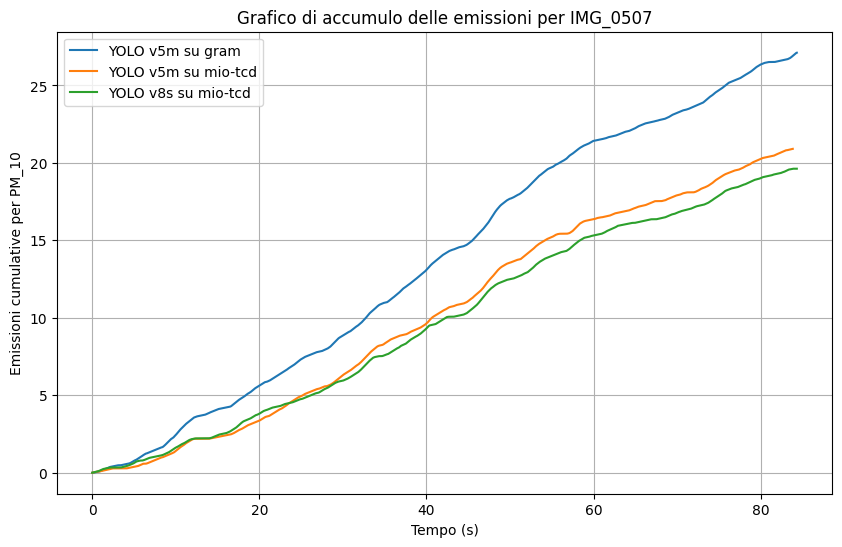

In [ ]:
cums = {}
vehs = []
fps = 120
i = 0
for model_name, input_folder in zip(names, input_folders):
    results = import_results(input_folder)
    cum, veh = history(results[videos_list[i]])
    cums[model_name] = cum


plt.figure(figsize=(10, 6))

# Plotta le distribuzioni
for nam, cum in cums.items():
    time_in_seconds = [f / fps for f in range(len(cum))]
    plt.plot(time_in_seconds, cum, label=f"{nam}")
#plt.plot(veh, alpha=0.5, label="Veicoli tracciati da YOLO 8")

plt.xlabel('Tempo (s)')
plt.ylabel('Emissioni cumulative per PM_10')
plt.title(f'Grafico di accumulo delle emissioni per {videos_list[i]}')
plt.legend()
plt.grid(True)

# Mostra il grafico
plt.show()